In [1]:
import itertools
import datetime as dt

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Noto Sans CJK JP'
import seaborn as sns
import tqdm
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from utils.scaler import STMatrixStandardScaler
from utils.helper import format_stmatrix, train_test_split, fix_seed, seed_worker
# from dataset import STDataset
from encdec.dataset import STDataset
# from trainer import Trainer
from encdec.trainer import Trainer
from logger import Logger
import config

In [2]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=2)

## 前処理してデータセットを作成
- 渋滞量 -> フラグに変換
- 方向 -> 0/1に変換
    - 上り: 0, 下り: 1
- 四半期を数値化
- 使用しないカラムを落とす
    - 天気 + `index`, `data`, `road_code`, `jam_type`
- 速度の欠損を埋める
- OCC -> [0, 1]に変換
- 型変換
    - float64 -> float32
    - 区間の名前, コード, 県コード, 0/1系, カレンダーデータをcategoryデータに
    - degreeをint32

In [ ]:
# 道路名
# TARGET_ROAD='tateyama'
TARGET_ROAD='kannetsu'

# 交通量
PROCESSED_DATA_DIR = '../Input_processed_data'
TRAFFIC_DIR = f'{PROCESSED_DATA_DIR}/traffic'
TRAFFIC_CSV = f'{TRAFFIC_DIR}/{TARGET_ROAD}_20220621all-merged_filled_1h.csv'

In [ ]:
col_types = {'start_code': str, 'end_code': str, 'road_code': str, 'jam_type': str,}

df = pd.read_csv(TRAFFIC_CSV, parse_dates=True, index_col='datetime', dtype=col_types).reset_index()

In [ ]:
def linear_interpolate(df, col):
    '''
    dfのcolカラム内の欠損を区間ごとに線形補間する
    '''
    f = lambda g: g.interpolate(method='linear', axis=0)
    
    df.sort_values('datetime', inplace=True)
    df[col] = df.groupby(['start_code', 'end_code'])[col].apply(f)
    return df


def preprocess(df):
    # 「年」情報を入れる
    df['year'] = df['datetime'].dt.year
    # 渋滞フラグ 0/1
    df['jam_quantity'] = np.where(df['speed'] < 40, 1, 0)
    # 方向を数値化
    direction_map = {'上り': 0, '下り': 1}
    df['direction'] = df['direction'].map(direction_map)
    # 四半期を数値化
    df['quarter'] = df['quarter'].str[-1]
    
    # object型のカラム, いらないカラムを落とす
    drop_cols = [
        'index', 'date', 'road_code', 'pressure', 'rainfall', 
        'temperature', 'humidity', 'wind_speed', 'daylight_hours', 
        'snowfall', 'deepest_snowfall', 'weather_description', 'jam_type'
    ]
    df.drop(drop_cols, axis=1, inplace=True)
    
    # 速度の欠損を埋める
    df = linear_interpolate(df, 'speed')
    # OCCを[0,1]に変換
    df['OCC'] = df['OCC'] / 100.0
    
    # 型変換
    f64_cols = df.select_dtypes(include=[np.float64]).columns
    df.loc[:, f64_cols] = df.loc[:, f64_cols].astype(np.float32)
    i64_cols = df.select_dtypes(include=[int]).columns
    df.loc[:, i64_cols] = df.loc[:, i64_cols].astype(np.int32)
    
    type_map = {
        'start_name': 'category',
        'end_name': 'category',
        'start_code': 'category',
        'end_code': 'category',
        'start_pref_code': 'category',
        'end_pref_code': 'category',
        'direction': 'category',
        'month': 'category',
        'day': 'category',
        'dayofweek': 'category',
        'is_holiday': 'category',
        'hour': 'category',
        'quarter': 'category',
        'jam_quantity': 'category',
        'start_degree': np.int32,
        'end_degree': np.int32,
        'degree_sum': np.int32,
    }
    df = df.astype(type_map)
    
    return df

In [ ]:
def create_dataset(df, start_date, end_date, pkl_name):
    tmp = df.loc[(df['datetime'] >= pd.Timestamp(start_date)) & (df['datetime'] < pd.Timestamp(end_date))]
    # tmp.reset_index(drop=True, inplace=True)
    
    tmp = preprocess(tmp.copy())
    tmp.reset_index(drop=True, inplace=True)
    
    tmp.to_pickle(pkl_name)

# whole dataset
start_date = '2021/4/2'
end_date = '2022/6/1'
pkl_name = './datasets_1h/kannetsu_210402-220531.pkl'

create_dataset(df, start_date, end_date, pkl_name)

# mini dataset
start_date = '2021/4/2'
end_date = '2021/6/1'
pkl_name = './datasets_1h/kannetsu_210402-210531.pkl'

create_dataset(df, start_date, end_date, pkl_name)

## データセットを読み込む

In [ ]:
# mini
df_test = pd.read_pickle('./datasets_1h/kannetsu_210402-210531.pkl')
# whole
df_all = pd.read_pickle('./datasets_1h/kannetsu_210402-220531.pkl')

In [ ]:
dt_table = pd.read_pickle(f'{config.TABLES_DIR}/datetime_table.pkl')
sec_table = pd.read_pickle(f'{config.TABLES_DIR}/section_table.pkl')

In [ ]:
df_test.head(3)

### 時間, 区間にembedding用のIDを割り振る

In [ ]:
# 時間情報を管理するためのテーブルを作成 (month x hour x dayofweeks x is_holidays)
# months = range(1, 12+1)
# hours = range(24)
# dayofweeks = range(1, 7+1)
# is_holidays = (0, 1)

# dt_table = pd.DataFrame(itertools.product(months, hours, dayofweeks, is_holidays), columns=['month', 'hour', 'dayofweek', 'is_holiday'], dtype='category')
# dt_table = dt_table.query('dayofweek not in (6, 7) | is_holiday != 0').reset_index(drop=True)
# dt_table = dt_table.reset_index().set_index(['month', 'hour', 'dayofweek', 'is_holiday']).astype('category')

# dt_table.to_pickle('./datasets/datetime_table.pkl')

# dt_table = pd.read_pickle('./datasets/datetime_table.pkl')

In [ ]:
# 時間情報を管理するためのテーブルを作成 (hour x dayofweeks x is_holidays)
# hours = range(24)
# dayofweeks = range(1, 7+1)
# is_holidays = (0, 1)

# dt_table = pd.DataFrame(itertools.product(hours, dayofweeks, is_holidays), columns=['hour', 'dayofweek', 'is_holiday'], dtype='category')
# dt_table = dt_table.query('dayofweek not in (6, 7) | is_holiday != 0').reset_index(drop=True)
# dt_table = dt_table.reset_index().set_index(['hour', 'dayofweek', 'is_holiday']).astype('category')

# dt_table.to_pickle('./datasets/mini_datetime_table.pkl')

# dt_table = pd.read_pickle('./datasets/mini_datetime_table.pkl')

In [ ]:
# 区間情報を管理するためのテーブルを作成
# sec_table = df_test[['start_name', 'end_name', 'direction', 'KP']].drop_duplicates()
# 区間順にソート
# sort_f = lambda g: g.sort_values('KP', ascending=(g.name == 1))
# sec_table = sec_table.groupby('direction').apply(sort_f).reset_index(drop=True)

# sec_table.to_pickle('./datasets/section_table.pkl')
# sec_table.head(3)

# sec_table = pd.read_pickle('./datasets/section_table.pkl')

In [ ]:
def datetime2id(df, dt_table):
    time_col = ['hour', 'dayofweek', 'is_holiday']
    f = lambda g: g.assign(datetime_id=dt_table.loc[g.name, 'index'])
    df = df.groupby(time_col).apply(f)
    df['datetime_id'] = df['datetime_id'].astype('category')
    return df


def section2id(df, sec_table):
    f = lambda g: g.assign(section_id=sec_table.query(f'start_name == "{g.name[0]}" & end_name == "{g.name[1]}"').index.item())
    df = df.groupby(['start_name', 'end_name']).apply(f)
    df['section_id'] = df['section_id'].astype('category')
    return df


def identify(df, dt_table, sec_table):
    df = datetime2id(df, dt_table)
    df = section2id(df, sec_table)
    return df

In [ ]:
df_test = identify(df_test, dt_table, sec_table)
df_test.to_pickle('./datasets_1h/kannetsu_210402-210531.pkl')

df_all = identify(df_all, dt_table, sec_table)
df_all.to_pickle('./datasets_1h/kannetsu_210402-220531.pkl')

## Train, Testに分割

In [ ]:
# train: 2021/4/2 - 2022/2/28
# test: 2022/3/1 - 2022/5/31
df_all = pd.read_pickle('./datasets_1h/kannetsu_210402-220531.pkl')

sep_date = '2022/3/1'
df_train = df_all.loc[df_all['datetime'] < pd.Timestamp(sep_date)]
df_test = df_all.loc[df_all['datetime'] >= pd.Timestamp(sep_date)]

df_train.to_pickle('./datasets_1h/kannetsu_210402-220228.pkl')
df_test.to_pickle('./datasets_1h/kannetsu_220301-220531.pkl')

In [ ]:
# train: 2021/4/2 - 2021/5/19
# test: 2021/5/20 - 2021/5/31
df_mini = pd.read_pickle('./datasets_1h/kannetsu_210402-210531.pkl')

sep_date = '2021/5/20'
df_train = df_mini.loc[df_mini['datetime'] < pd.Timestamp(sep_date)]
df_test = df_mini.loc[df_mini['datetime'] >= pd.Timestamp(sep_date)]

df_train.to_pickle('./datasets_1h/kannetsu_210402-210519.pkl')
df_test.to_pickle('./datasets_1h/kannetsu_210520-210531.pkl')

## Spatial Temporal Matrixに整形
- 区間数 x 時系列数 の行列
- 実際は 区間数 x 時系列数 x 特徴量数 のテンソル

In [ ]:
df_test_tr = pd.read_pickle('./datasets_1h/kannetsu_210402-210519.pkl')
df_test_va = pd.read_pickle('./datasets_1h/kannetsu_210520-210531.pkl')

df_all_tr = pd.read_pickle('./datasets_1h/kannetsu_210402-220228.pkl')
df_all_va = pd.read_pickle('./datasets_1h/kannetsu_220301-220531.pkl')

dt_table = pd.read_pickle(f'{config.TABLES_DIR}/datetime_table.pkl')
sec_table = pd.read_pickle(f'{config.TABLES_DIR}/section_table.pkl')

In [ ]:
# 特徴量の元になる列
# time_col = ['month', 'hour', 'dayofweek', 'is_holiday']
# section_col = ['direction', 'lane_count', 'KP']
time_col = ['datetime_id']
section_col = ['section_id']
search_col = ['search_1h', 'search_unspec_1d']
traffic_col = ['allCars']

feature_col = time_col + section_col + search_col + traffic_col
# feature_col = time_col + section_col + traffic_col
# feature_col = search_col + traffic_col

# 予測対象
target_col = 'allCars'

In [ ]:
X_tr, y_tr = format_stmatrix(df_all_tr, sec_table, feature_col, config.TARGET_COL)
X_va, y_va = format_stmatrix(df_all_va, sec_table, feature_col, config.TARGET_COL)
print(X_tr.shape, X_va.shape, y_tr.shape, y_va.shape)

In [ ]:
# torch.save(X_tr, './datasets_1h/features_train.pkl')
# torch.save(X_va, './datasets_1h/features_test.pkl')
# torch.save(y_tr, './datasets_1h/labels_train.pkl')
# torch.save(y_va, './datasets_1h/labels_test.pkl')

# torch.save(X_tr, f'datasets_1h/mini_features_train.pkl')
# torch.save(X_va, f'datasets_1h/mini_features_test.pkl')
# torch.save(y_tr, f'datasets_1h/mini_labels_train.pkl')
# torch.save(y_va, f'datasets_1h/mini_labels_test.pkl')

## 標準化・正規化
- 標準化を行う
- 時間特徴量（`month`, `hour`, `day_of_week`）はsin, cosで変換するのもやってみる
- 検索数, 台数は上り・下り別でもやってみる

In [ ]:
dt_table = pd.read_pickle(f'{config.TABLES_DIR}/datetime_table.pkl')
sec_table = pd.read_pickle(f'{config.TABLES_DIR}/section_table.pkl')

X_tr = torch.load('./datasets_1h/features_train.pkl')
X_va = torch.load('./datasets_1h/features_test.pkl')
y_tr = torch.load('./datasets_1h/labels_train.pkl')
y_va = torch.load('./datasets_1h/labels_test.pkl')

# X_tr = torch.load(f'datasets_1h/mini_features_train.pkl')
# X_va = torch.load(f'datasets_1h/mini_features_test.pkl')
# y_tr = torch.load(f'datasets_1h/mini_labels_train.pkl')
# y_va = torch.load(f'datasets_1h/mini_labels_test.pkl')

print(X_tr.shape, X_va.shape)
print(y_tr.shape, y_va.shape)

In [ ]:
# ID列は飛ばして標準化
skip_features = [0, 1]
scaler = STMatrixStandardScaler(skip_features=skip_features)

scaler.fit(X_tr)
X_tr_norm = scaler.transform(X_tr)

scaler.fit(X_va)
X_va_norm = scaler.transform(X_va)

# torch.save(X_tr_norm, f'datasets_1h/features_train_norm.pkl')
# torch.save(X_va_norm, f'datasets_1h/features_test_norm.pkl')

## データセットの定義

In [3]:
dt_table = pd.read_pickle(f'{config.TABLES_DIR}/datetime_table.pkl')
sec_table = pd.read_pickle(f'{config.TABLES_DIR}/section_table.pkl')

X_tr = torch.load(f'{config.DATASET_DIR}_1h/features_train_norm.pkl')
X_va = torch.load(f'{config.DATASET_DIR}_1h/features_test_norm.pkl')
y_tr = torch.load(f'{config.DATASET_DIR}_1h/labels_train.pkl')
y_va = torch.load(f'{config.DATASET_DIR}_1h/labels_test.pkl')

# X_tr = torch.load(f'datasets_1h/mini_features_train_norm.pkl')
# X_va = torch.load(f'datasets_1h/mini_features_test_norm.pkl')
# y_tr = torch.load(f'datasets_1h/mini_labels_train.pkl')
# y_va = torch.load(f'datasets_1h/mini_labels_test.pkl')

print(dt_table.shape, sec_table.shape)
print(X_tr.shape, X_va.shape)
print(y_tr.shape, y_va.shape)

(288, 1) (63, 4)
torch.Size([5, 7992, 63]) torch.Size([5, 2208, 63])
torch.Size([1, 7992, 63]) torch.Size([1, 2208, 63])


In [4]:
time_step = 7 * 24
space_window = (-2, 2)

dataset_train = STDataset(X_tr, y_tr, 
                          time_step=time_step, 
                          space_window=space_window)

dataset_valid = STDataset(X_va, y_va, 
                          time_step=time_step, 
                          space_window=space_window)

## Networkの定義

In [5]:
TRAFFIC_CONV = 64
TRAFFIC_HIDDEN = 128
TRAFFIC_LSTM_LAYERS = 2
TRAFFIC_KERNEL = (7,5)

SEARCH_CONV = 64
SEARCH_HIDDEN = 128
SEARCH_LSTM_LAYERS = 2
SEARCH_KERNEL = (7,5)

UNSPEC_SEARCH_HIDDEN = 64
UNSPEC_SEARCH_KERNEL = 5

DATETIME_EMB = 32
ROAD_EMB = 16

FC_EMB = 32

In [384]:
class LSTMEncoder(nn.Module):
    def __init__(self, bidirectional=True):
        super().__init__()
        
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(1, TRAFFIC_HIDDEN, TRAFFIC_LSTM_LAYERS, bidirectional=bidirectional, dropout=0.4, batch_first=True)
    
    def forward(self, x):
        N, T, S = x.shape
        x = x[..., [S // 2]]
        # N x T x 1 -> N x T x H, (L x N x H, L x N x H)
        outs, (h, c) = self.lstm(x)
        
        if self.bidirectional:
            # 2*L_t x N x H_t -> L_t x N x 2*H_t
            L2, N, H_t = h.shape
            h = h.transpose(0,1).reshape(N, L2 // 2, -1).transpose(0,1).contiguous()
            c = h.transpose(0,1).reshape(N, L2 // 2, -1).transpose(0,1).contiguous()    
        
        return outs, (h, c)
    

class LSTMDecoder(nn.Module):
    def __init__(self, bidirectional=True):
        super().__init__()
        
        self.dropout_ratio = 0.3
        
        self.hid_dim = 2 * TRAFFIC_HIDDEN if bidirectional else TRAFFIC_HIDDEN
        
        self.lstm = nn.LSTM(1, self.hid_dim, TRAFFIC_LSTM_LAYERS, dropout=self.dropout_ratio, batch_first=True)
        self.fc1 = nn.Linear(self.hid_dim, FC_EMB)
        self.fc2 = nn.Linear(FC_EMB, 1)

    def forward(self, x, state):
        N, _, P = x.shape
        
        # N x C=1 x P -> N x P x C=1
        x = x.permute(0, 2, 1)
        # N x P x C, (L x N x H_t, L x N x H_t) -> N x P x H_t, (L x N x H_t, L x N x H_t)
        outs, state = self.lstm(x, state)
        outs = F.relu(self.fc1(outs))
        outs = self.fc2(outs)

        return outs, state
    
    def generate(self, trf_enc, start_value=-1.0):
        with torch.no_grad():
            # N x 1 x 1
            N = trf_enc[0].shape[1]
            out = torch.tensor(start_value).repeat(N).unsqueeze(-1).unsqueeze(-1)
            out = out.to(trf_enc[0].device)
            
            state = trf_enc
            
            generated = []

            for i in range(24):
                out, state = self.forward(out, state)
                generated.append(out)
        
        # N x P x 1
        generated = torch.cat(generated, dim=1)
        # N x P x 1 -> N x P
        generated = generated[..., 0]
        return generated
    

class LSTMOnlyEncoderDecoder(nn.Module):
    def __init__(self, bidirectional=True):
        super().__init__()
        
        self.encoder = LSTMEncoder(bidirectional=bidirectional)
        self.decoder = LSTMDecoder(bidirectional=bidirectional)
        
    def forward(self, features, decoder_xs):
        dt, rd, sr, un_sr, trf = features
        
        outs_trf, state_trf = self.encoder(trf)
        outs, _ = self.decoder(decoder_xs, state_trf)
        outs = outs[..., 0]
        return outs
    
    def generate(self, features, start_value=-1.0):
        dt, rd, sr, un_sr, trf = features
        
        outs_trf, state_trf = self.encoder(trf)    
        generated = self.decoder.generate(state_trf, start_value)
        return generated

In [385]:
(dt, rd, sr, un_sr, trf), labels = dataset_train[:16]
print(trf.shape, labels.shape)

torch.Size([16, 168, 5]) torch.Size([16, 1, 24])


In [386]:
(outs_trf, state_trf) = LSTMEncoder()(trf)
print(outs_trf.shape, state_trf[0].shape)

decoded, _ = LSTMDecoder()(labels, state_trf)
print(decoded.shape)

predicted = LSTMOnlyEncoderDecoder().generate((dt, rd, sr, un_sr, trf))
print(predicted.shape)

torch.Size([16, 168, 256]) torch.Size([2, 16, 256])
torch.Size([16, 24, 1])
torch.Size([16, 24])


In [387]:
features, labels = dataset_train[:16]

In [388]:
decoder_xs = torch.full_like(labels, -1)
decoder_xs[..., 1:] = labels[..., :-1]

In [389]:
out = LSTMOnlyEncoderDecoder()((dt, rd, sr, un_sr, trf), decoder_xs)
out.shape

torch.Size([16, 24])

In [400]:
class CNNLSTMEncoder(nn.Module):
    def __init__(self, bidirectional=True):
        super().__init__()
        
        self.bidirectional = bidirectional
        
        self.conv = nn.Conv2d(1, TRAFFIC_CONV, TRAFFIC_KERNEL, padding=(TRAFFIC_KERNEL[0]//2, 0), padding_mode='replicate')
        self.lstm = nn.LSTM(TRAFFIC_CONV, TRAFFIC_HIDDEN, TRAFFIC_LSTM_LAYERS, bidirectional=bidirectional, dropout=0.4, batch_first=True)
    
    def forward(self, x):
        N, T, S = x.shape
        
        out = F.relu(self.conv(x.unsqueeze(1)))
        # N x C x T -> N x T x C
        out = out[..., 0].permute(0, 2, 1)
        # N x T x C -> N x T x H, (L x N x H, L x N x H)
        outs, (h, c) = self.lstm(out)
        
        if self.bidirectional:
            # 2*L_t x N x H_t -> L_t x N x 2*H_t
            L2, N, H_t = h.shape
            h = h.transpose(0,1).reshape(N, L2 // 2, -1).transpose(0,1).contiguous()
            c = h.transpose(0,1).reshape(N, L2 // 2, -1).transpose(0,1).contiguous()
        
        return outs, (h, c)
    

class CNNLSTMEncoderDecoder(LSTMOnlyEncoderDecoder):
    def __init__(self, bidirectional=True):
        super().__init__()
        
        self.encoder = CNNLSTMEncoder(bidirectional=bidirectional)
        self.decoder = LSTMDecoder(bidirectional=bidirectional)

In [401]:
(dt, rd, sr, un_sr, trf), labels = dataset_train[:16]
print(trf.shape, labels.shape)

torch.Size([16, 168, 5]) torch.Size([16, 1, 24])


In [402]:
(outs_trf, state_trf) = CNNLSTMEncoder()(trf)
print(outs_trf.shape, state_trf[0].shape)

decoded, _ = LSTMDecoder()(labels, state_trf)
print(decoded.shape)

predicted = LSTMOnlyEncoderDecoder().generate((dt, rd, sr, un_sr, trf))
print(predicted.shape)

torch.Size([16, 168, 256]) torch.Size([2, 16, 256])
torch.Size([16, 24, 1])
torch.Size([16, 24])


In [403]:
features, labels = dataset_train[:16]

In [404]:
decoder_xs = torch.full_like(labels, -1)
decoder_xs[..., 1:] = labels[..., :-1]

In [405]:
out = CNNLSTMEncoderDecoder()((dt, rd, sr, un_sr, trf), decoder_xs)
out.shape

torch.Size([16, 24])

In [410]:
class LSTMEmbeddingDecoder(nn.Module):
    def __init__(self, bidirectional=True):
        super().__init__()
        
        self.dropout_ratio = 0.3
        
        self.hid_dim = 2 * TRAFFIC_HIDDEN if bidirectional else TRAFFIC_HIDDEN
        
        self.datetime_embedding = CategoricalEmbedding(config.DT_TABLE_SIZE, DATETIME_EMB)
        self.road_embedding = CategoricalEmbedding(config.SEC_TABLE_SIZE, ROAD_EMB)
        self.emb_dropout = nn.Dropout(p=0.4)
        
        self.lstm = nn.LSTM(1, self.hid_dim, TRAFFIC_LSTM_LAYERS, dropout=self.dropout_ratio, batch_first=True)
        self.fc1 = nn.Linear(self.hid_dim + DATETIME_EMB + ROAD_EMB, FC_EMB)
        self.fc2 = nn.Linear(FC_EMB, 1)

    def forward(self, x, state, dt, rd):
        N, _, P = x.shape
        
        # N x C=1 x P -> N x P x C=1
        x = x.permute(0, 2, 1)
        # N x P x C, (L x N x H_t, L x N x H_t) -> N x P x H_t, (L x N x H_t, L x N x H_t)
        outs, state = self.lstm(x, state)
        
        # N x P -> N x P x H_d
        dt_emb = self.datetime_embedding(dt)
        dt_emb = self.emb_dropout(dt_emb)
        # N x 1 -> N x 1 x H_r
        rd_emb = self.road_embedding(rd)
        rd_emb = self.emb_dropout(rd_emb)
        
        outs = torch.cat([
            dt_emb, 
            rd_emb.repeat(1, P, 1), 
            outs
        ], dim=-1)
        
        outs = F.relu(self.fc1(outs))
        outs = self.fc2(outs)

        return outs, state
    
    def generate(self, trf_enc, dt, rd, start_value=-1.0):
        with torch.no_grad():
            # N x 1 x 1
            N = trf_enc[0].shape[1]
            out = torch.tensor(start_value).repeat(N).unsqueeze(-1).unsqueeze(-1)
            out = out.to(trf_enc[0].device)
            
            state = trf_enc
            
            generated = []

            for i in range(24):
                out, state = self.forward(out, state, dt[:, [i]], rd)
                generated.append(out)
        
        # N x P x 1
        generated = torch.cat(generated, dim=1)
        # N x P x 1 -> N x P
        generated = generated[..., 0]
        return generated
    

class CNNLSTMEmbeddingEncoderDecoder(nn.Module):
    def __init__(self, bidirectional=True):
        super().__init__()
        
        self.encoder = CNNLSTMEncoder(bidirectional=bidirectional)
        self.decoder = LSTMEmbeddingDecoder(bidirectional=bidirectional)
        
    def forward(self, features, decoder_xs):
        dt, rd, sr, un_sr, trf = features
        
        outs_trf, state_trf = self.encoder(trf)
        outs, _ = self.decoder(decoder_xs, state_trf, dt, rd)
        outs = outs[..., 0]
        return outs
    
    def generate(self, features, start_value=-1.0):
        dt, rd, sr, un_sr, trf = features
        
        outs_trf, state_trf = self.encoder(trf)    
        generated = self.decoder.generate(state_trf, dt, rd, start_value)
        return generated

In [411]:
(dt, rd, sr, un_sr, trf), labels = dataset_train[:16]
print(trf.shape, labels.shape)

torch.Size([16, 168, 5]) torch.Size([16, 1, 24])


In [412]:
(outs_trf, state_trf) = CNNLSTMEncoder()(trf)
print(outs_trf.shape, state_trf[0].shape)

decoded, _ = LSTMEmbeddingDecoder()(labels, state_trf, dt, rd)
print(decoded.shape)

predicted = CNNLSTMEmbeddingEncoderDecoder().generate((dt, rd, sr, un_sr, trf))
print(predicted.shape)

torch.Size([16, 168, 256]) torch.Size([2, 16, 256])
torch.Size([16, 24, 1])
torch.Size([16, 24])


In [413]:
features, labels = dataset_train[:16]

In [414]:
decoder_xs = torch.full_like(labels, -1)
decoder_xs[..., 1:] = labels[..., :-1]

In [415]:
out = CNNLSTMEncoderDecoder()((dt, rd, sr, un_sr, trf), decoder_xs)
out.shape

torch.Size([16, 24])

### Attention Encoder-Decoder

In [22]:
class TrafficSearchEncoder(nn.Module):
    def __init__(self, conv_dim, kernel, lstm_dim, lstm_layers, bidirectional=True):
        super().__init__()
        
        self.bidirectional = bidirectional
        
        self.conv = nn.Conv2d(1, conv_dim, kernel, padding=(kernel[0]//2, 0), padding_mode='replicate')
        # self.lstm = nn.LSTM(conv_dim, lstm_dim, lstm_layers, bidirectional=bidirectional, batch_first=True)
        self.lstm = nn.LSTM(conv_dim, lstm_dim, lstm_layers, bidirectional=bidirectional, dropout=0.4, batch_first=True)
        
    
    def forward(self, x):
        N, T, S = x.shape
        
        out = F.relu(self.conv(x.unsqueeze(1)))
        # N x C x T -> N x T x C
        out = out[..., 0].permute(0, 2, 1)
        # N x T x C -> N x T x H, (L x N x H, L x N x H)
        outs, (h, c) = self.lstm(out)
        
        return outs, (h, c)

    
class SearchUnspecEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv = nn.Conv1d(1, UNSPEC_SEARCH_HIDDEN, UNSPEC_SEARCH_KERNEL, padding_mode='replicate')
        # self.dropout = nn.Dropout(p=0)
        self.dropout = nn.Dropout(p=0.4)
    
    def forward(self, x):
        N, T, S = x.shape
        out = F.relu(self.conv(x))
        # N x C x T -> N x T x C
        out = out.permute(0, 2, 1)
        out = self.dropout(out)
        
        return out

    
class Encoder(nn.Module):
    def __init__(self, include_search=True, bidirectional=True):
        super().__init__()
        
        self.include_search = include_search
        self.bidirectional = bidirectional
        
        self.traffic_encoder = TrafficSearchEncoder(TRAFFIC_CONV, TRAFFIC_KERNEL, TRAFFIC_HIDDEN, TRAFFIC_LSTM_LAYERS, bidirectional=bidirectional)
        if include_search:
            self.search_encoder = TrafficSearchEncoder(SEARCH_CONV, SEARCH_KERNEL, SEARCH_HIDDEN, SEARCH_LSTM_LAYERS, bidirectional=bidirectional)
            self.unspec_search_encoder = SearchUnspecEncoder()
        
    def forward(self, x_trf, x_sr, x_un_sr):
        # N x T x S -> N x T x H_t, (bi*L_t x N x H_t, bi*L_t x N x H_t)
        outs_trf, state_trf = self.traffic_encoder(x_trf)
        if self.bidirectional:
            # 2*L_t x N x H_t -> L_t x N x 2*H_t
            L2, N, H_t = state_trf[0].shape
            h = state_trf[0].transpose(0,1).reshape(N, L2 // 2, -1).transpose(0,1).contiguous()
            c = state_trf[1].transpose(0,1).reshape(N, L2 // 2, -1).transpose(0,1).contiguous()
            state_trf = (h, c)
        
        if self.include_search:
            # N x P x S -> N x P x H_s, (L_s x N x H_s, L_s x N x H_s) 
            outs_sr, state_sr = self.search_encoder(x_sr)
            # N x 1 x S -> N x 1 x H_u
            out_un_sr = self.unspec_search_encoder(x_un_sr)
            return (outs_trf, state_trf), outs_sr, out_un_sr
        return outs_trf, state_trf

In [23]:
class CategoricalEmbedding(nn.Module):
    def __init__(self, category_size, emb_size):
        super().__init__()

        self.category_size = category_size
        self.emb_size = emb_size
        self.embedding = nn.Embedding(category_size, emb_size)

    def forward(self, x):
        out = self.embedding(x.to(dtype=torch.int64))
        return out

In [41]:
# https://github.com/sooftware/attentions/blob/master/attentions.py
class DotProductAttention(nn.Module):
    def __init__(self, scaled=False):
        super().__init__()
        
        self.scaled = scaled

    def forward(self, query, value):
        # query: N x P x H
        # value: N x T x H
       
        # (N x P x H) x (N x H x T) -> N x P x T
        score = torch.bmm(query, value.transpose(1, 2))
        if self.scaled:
            D = value.shape[-1]
            score /= np.sqrt(D)
        attn = F.softmax(score, dim=-1)
        # (N x P x T) x (N x T x H) -> N x P x H
        context = torch.bmm(attn, value)
        
        return context, attn

In [105]:
class TrafficDecoder(nn.Module):
    def __init__(self, bidirectional=True):
        super().__init__()
        
        self.dropout_ratio = 0.3
        
        self.hid_dim = 2 * TRAFFIC_HIDDEN if bidirectional else TRAFFIC_HIDDEN
        self.bnorm = nn.BatchNorm1d(1)
        # self.lstm = nn.LSTM(1, self.hid_dim, TRAFFIC_LSTM_LAYERS, batch_first=True)
        self.lstm = nn.LSTM(1, self.hid_dim, TRAFFIC_LSTM_LAYERS, dropout=self.dropout_ratio, batch_first=True)

    def forward(self, x, state):
        N, _, P = x.shape
        # normalize
        x = self.bnorm(x)
        # N x C=1 x P -> N x P x C=1
        x = x.permute(0, 2, 1)
        # N x P x C, (L x N x H_t, L x N x H_t) -> N x P x H_t, (L x N x H_t, L x N x H_t)
        outs, state = self.lstm(x, state)
        return outs, state
    
    
class AttentionTrafficDecoder(nn.Module):
    def __init__(self, bidirectional=True):
        super().__init__()
        
        self.dropout_ratio = 0.3
        
        self.hid_dim = 2 * TRAFFIC_HIDDEN if bidirectional else TRAFFIC_HIDDEN
        self.bnorm = nn.BatchNorm1d(1)
        self.lstm1 = nn.LSTM(1, self.hid_dim, dropout=self.dropout_ratio, batch_first=True)
        self.attention = DotProductAttention()
        self.lstm2 = nn.LSTM(self.hid_dim, self.hid_dim, TRAFFIC_LSTM_LAYERS-1, dropout=self.dropout_ratio, batch_first=True)

    def forward(self, x, enc_out, state):
        N, _, P = x.shape
        
        # normalize
        x = self.bnorm(x)
        
        # N x C=1 x P -> N x P x C=1
        x = x.permute(0, 2, 1)
        # L x N x H_t -> (1 x N x H_t, L-1 x N x H_t)
        state1 = (state[0][:1], state[1][:1])
        state2 = (state[0][1:], state[1][1:])
        
        # N x P x C, (L x N x H_t, L x N x H_t) -> N x P x H_t, (L x N x H_t, L x N x H_t)
        outs, state1 = self.lstm1(x, state1)
        contexts, attn_weight = self.attention(outs, enc_out)
        outs, state2 = self.lstm2(contexts, state2)
        
        # (1 x N x H_t, L-1 x N x H_t) -> L x N x H_t
        state = (
            torch.cat([state1[0], state2[0]], dim=0),
            torch.cat([state1[1], state2[1]], dim=0),
        )
        
        return outs, state, contexts

In [97]:
class AffineDecoder(nn.Module):
    def __init__(self, include_search=True, bidirectional=True):
        super().__init__()
        
        self.include_search = include_search
        self.bidirectional = bidirectional
        
        if include_search:
            if bidirectional:
                self.n_dim = 2*TRAFFIC_HIDDEN + 2*SEARCH_HIDDEN + UNSPEC_SEARCH_HIDDEN + DATETIME_EMB + ROAD_EMB
            else:
                self.n_dim = TRAFFIC_HIDDEN + SEARCH_HIDDEN + UNSPEC_SEARCH_HIDDEN + DATETIME_EMB + ROAD_EMB
        else:
            if bidirectional:
                self.n_dim = 2*TRAFFIC_HIDDEN + DATETIME_EMB + ROAD_EMB
            else:
                self.n_dim = TRAFFIC_HIDDEN + DATETIME_EMB + ROAD_EMB
        
        self.datetime_embedding = CategoricalEmbedding(config.DT_TABLE_SIZE, DATETIME_EMB)
        self.road_embedding = CategoricalEmbedding(config.SEC_TABLE_SIZE, ROAD_EMB)
        # self.emb_dropout = nn.Dropout(p=0)
        self.emb_dropout = nn.Dropout(p=0.4)
        
        self.fc1 = nn.Linear(self.n_dim, FC_EMB)
        self.fc2 = nn.Linear(FC_EMB, 1)
        
    def forward(self, trf_dec, sr_enc, un_sr_enc, dt, rd):
        # traffic_dec: N x P x H_t
        N, P, H_t = trf_dec.shape
        
        # N x P -> N x P x H_d
        dt_emb = self.datetime_embedding(dt)
        dt_emb = self.emb_dropout(dt_emb)
        # N x 1 -> N x 1 x H_r
        rd_emb = self.road_embedding(rd)
        rd_emb = self.emb_dropout(rd_emb)
        
        if self.include_search:
            outs = torch.cat([
                dt_emb, 
                rd_emb.repeat(1, P, 1), 
                sr_enc, 
                un_sr_enc.repeat(1, P, 1),
                trf_dec
            ], dim=-1)
        else:
            outs = torch.cat([
                dt_emb, 
                rd_emb.repeat(1, P, 1), 
                trf_dec
            ], dim=-1)
        # N x P x SUM -> N x P x H_fc
        outs = F.relu(self.fc1(outs))
        # N x P x H_fc -> N x P x 1
        outs = self.fc2(outs)
        
        return outs
    
    
class AttentionAffineDecoder(nn.Module):
    def __init__(self, include_search=True, bidirectional=True):
        super().__init__()
        
        self.include_search = include_search
        self.bidirectional = bidirectional
        
        if include_search:
            if bidirectional:
                self.n_dim = 4*TRAFFIC_HIDDEN + 2*SEARCH_HIDDEN + UNSPEC_SEARCH_HIDDEN + DATETIME_EMB + ROAD_EMB
            else:
                self.n_dim = 3*TRAFFIC_HIDDEN + SEARCH_HIDDEN + UNSPEC_SEARCH_HIDDEN + DATETIME_EMB + ROAD_EMB
        else:
            if bidirectional:
                self.n_dim = 4*TRAFFIC_HIDDEN + DATETIME_EMB + ROAD_EMB
            else:
                self.n_dim = 3*TRAFFIC_HIDDEN + DATETIME_EMB + ROAD_EMB
        
        self.datetime_embedding = CategoricalEmbedding(config.DT_TABLE_SIZE, DATETIME_EMB)
        self.road_embedding = CategoricalEmbedding(config.SEC_TABLE_SIZE, ROAD_EMB)
        # self.emb_dropout = nn.Dropout(p=0)
        self.emb_dropout = nn.Dropout(p=0.4)
        
        self.fc1 = nn.Linear(self.n_dim, FC_EMB)
        self.fc2 = nn.Linear(FC_EMB, 1)
        
    def forward(self, trf_dec, trf_cxt, sr_enc, un_sr_enc, dt, rd):
        # traffic_dec: N x P x H_t
        N, P, H_t = trf_dec.shape
        
        # N x P -> N x P x H_d
        dt_emb = self.datetime_embedding(dt)
        dt_emb = self.emb_dropout(dt_emb)
        # N x 1 -> N x 1 x H_r
        rd_emb = self.road_embedding(rd)
        rd_emb = self.emb_dropout(rd_emb)
        
        if self.include_search:
            outs = torch.cat([
                dt_emb, 
                rd_emb.repeat(1, P, 1), 
                sr_enc, 
                un_sr_enc.repeat(1, P, 1),
                trf_dec,
                trf_cxt
            ], dim=-1)
        else:
            outs = torch.cat([
                dt_emb, 
                rd_emb.repeat(1, P, 1), 
                trf_dec,
                trf_cxt
            ], dim=-1)
        # N x P x SUM -> N x P x H_fc
        outs = F.relu(self.fc1(outs))
        # N x P x H_fc -> N x P x 1
        outs = self.fc2(outs)
        
        return outs

In [90]:
class AttentionDecoder(nn.Module):
    def __init__(self, include_search=True, bidirectional=True, scaled=False):
        super().__init__()
        
        self.include_search = include_search
        
        self.traffic_decoder = TrafficDecoder(bidirectional)
        self.attention = DotProductAttention(scaled)
        self.affine_decoder = AffineDecoder(include_search=include_search, bidirectional=bidirectional)
    
    def forward(self, x, trf_enc_out, trf_enc_state, sr_enc, un_sr_enc, dt, rd):
        # N x 1 x P, (L x N x H_t, L x N x H_t) -> N x P x H_t, (L x N x H_t, L x N x H_t)
        outs_trf, state_trf = self.traffic_decoder(x, trf_enc_state)
        outs_trf, attn_weight = self.attention(outs_trf, trf_enc_out)
        outs = self.affine_decoder(outs_trf, sr_enc, un_sr_enc, dt, rd)
        # N x P x 1 -> N x P
        outs = outs[..., 0]
        return outs
    
    def generate(self, trf_enc_out, trf_enc_state, sr_enc, un_sr_enc, dt, rd, start_value=-1.0):
        with torch.no_grad():
            # N x 1 x 1
            N = trf_enc_out.shape[0]
            out = torch.tensor(start_value).repeat(N).unsqueeze(-1).unsqueeze(-1)
            out = out.to(trf_enc_out.device)
            
            state = trf_enc_state
            
            generated = []

            for i in range(24):
                out, state = self.traffic_decoder(out, state)
                out, attn = self.attention(out, trf_enc_out)
                if self.include_search:
                    out = self.affine_decoder(out, sr_enc[:, [i]], un_sr_enc, dt[:, [i]], rd)
                else:
                    out = self.affine_decoder(out, None, None, dt[:, [i]], rd)

                generated.append(out)
        
        # N x P x 1
        generated = torch.cat(generated, dim=1)
        # N x P x 1 -> N x P
        generated = generated[..., 0]
        return generated
    
    
class AttentionDecoder(nn.Module):
    def __init__(self, include_search=True, bidirectional=True, scaled=False):
        super().__init__()
        
        self.include_search = include_search
        
        self.traffic_decoder = AttentionTrafficDecoder(bidirectional)
        self.affine_decoder = AttentionAffineDecoder(include_search=include_search, bidirectional=bidirectional)
    
    def forward(self, x, trf_enc_out, trf_enc_state, sr_enc, un_sr_enc, dt, rd):
        # N x 1 x P, (L x N x H_t, L x N x H_t) -> N x P x H_t, (L x N x H_t, L x N x H_t)
        outs_trf, state_trf, cxts_trf = self.traffic_decoder(x, trf_enc_out, trf_enc_state)
        outs = self.affine_decoder(outs_trf, cxts_trf, sr_enc, un_sr_enc, dt, rd)
        # N x P x 1 -> N x P
        outs = outs[..., 0]
        return outs
    
    def generate(self, trf_enc_out, trf_enc_state, sr_enc, un_sr_enc, dt, rd, start_value=-1.0):
        with torch.no_grad():
            # N x 1 x 1
            N = trf_enc_out.shape[0]
            out = torch.tensor(start_value).repeat(N).unsqueeze(-1).unsqueeze(-1)
            out = out.to(trf_enc_out.device)
            
            state = trf_enc_state
            
            generated = []

            for i in range(24):
                out, state, context = self.traffic_decoder(out, trf_enc_out, state)
                if self.include_search:
                    out = self.affine_decoder(out, context, sr_enc[:, [i]], un_sr_enc, dt[:, [i]], rd)
                else:
                    out = self.affine_decoder(out, context, None, None, dt[:, [i]], rd)

                generated.append(out)
        
        # N x P x 1
        generated = torch.cat(generated, dim=1)
        # N x P x 1 -> N x P
        generated = generated[..., 0]
        return generated

In [91]:
class AttentionEncoderDecoder(nn.Module):
    def __init__(self, include_search=True, bidirectional=True, scaled=False):
        super().__init__()
        
        self.include_search = include_search
        
        self.encoder = Encoder(include_search=include_search, bidirectional=bidirectional)
        self.decoder = AttentionDecoder(include_search=include_search, bidirectional=bidirectional, scaled=scaled)
        
    def forward(self, features, decoder_xs):
        dt, rd, sr, un_sr, trf = features
        
        if self.include_search:
            (outs_trf, state_trf), outs_sr, outs_un_sr = self.encoder(trf, sr, un_sr)
        else:
            outs_trf, state_trf = self.encoder(trf, sr, un_sr)
            outs_sr, outs_un_sr = None, None
            
        # outs = self.decoder(decoder_xs, outs_trf, state_trf, outs_sr, outs_un_sr, dt, rd)
        outs = self.decoder(decoder_xs, outs_trf, state_trf, outs_sr, outs_un_sr, dt, rd)

        return outs
    
    def generate(self, features, start_value=-1.0):
        dt, rd, sr, un_sr, trf = features
        
        if self.include_search:
            (outs_trf, state_trf), outs_sr, outs_un_sr = self.encoder(trf, sr, un_sr)
        else:
            outs_trf, state_trf = self.encoder(trf, sr, un_sr)
            DotProductAttentions_sr, outs_un_sr = None, None
        
        generated = self.decoder.generate(outs_trf, state_trf, outs_sr, outs_un_sr, dt, rd, start_value)
        return generated

In [92]:
(dt, rd, sr, un_sr, trf), labels = dataset_train[:16]
print(trf.shape, labels.shape)

torch.Size([16, 168, 5]) torch.Size([16, 1, 24])


In [93]:
(outs_trf, state_trf), outs_sr, outs_un_sr = Encoder(include_search=True, bidirectional=True)(trf, sr, un_sr)
print(outs_trf.shape, state_trf[0].shape, outs_sr.shape, outs_un_sr.shape)

# (outs_trf, state_trf) = WithoutEncoder(bidirectional=False)(trf)
# print(outs_trf.shape, state_trf[0].shape)

torch.Size([16, 168, 256]) torch.Size([4, 16, 256]) torch.Size([16, 24, 256]) torch.Size([16, 1, 64])


In [96]:
AttentionTrafficDecoder()(labels, outs_trf, state_trf)[-1].shape

torch.Size([16, 24, 256])

In [98]:
predicted = AttentionDecoder(include_search=True, bidirectional=True).generate(outs_trf, state_trf, outs_sr, outs_un_sr, dt, rd)
print(predicted.shape)

# predicted = WithoutDecoder(bidirectional=False).generate(state_trf, dt, rd)

torch.Size([16, 24])


In [99]:
predicted = AttentionEncoderDecoder(include_search=True, bidirectional=True).generate((dt, rd, sr, un_sr, trf))
print(predicted.shape)

torch.Size([16, 24])


In [100]:
features, labels = dataset_train[:16]

In [101]:
decoder_xs = torch.full_like(labels, -1)
decoder_xs[..., 1:] = labels[..., :-1]

In [102]:
out = AttentionEncoderDecoder(include_search=True)((dt, rd, sr, un_sr, trf), decoder_xs)
out.shape

torch.Size([16, 24])

## 学習

In [114]:
def get_loader(dataset, batch_size=config.BATCH_SIZE, shuffle=False):
    g = torch.Generator()
    g.manual_seed(config.RANDOM_SEED)

    dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True, worker_init_fn=seed_worker, generator=g)
    return dataloader


def train(n_epochs, model, model_name=None, log_path=None):
    train_loader = get_loader(dataset_train)
    val_loader = get_loader(dataset_valid)
    
    # hyper parameters
    n_epochs = 100

    # model
    model = model.to(device)
    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.L1Loss()

    logger = Logger(fname=log_path)
    trainer = Trainer(model, optimizer, loss_fn, device=device, logger=logger, model_name=model_name)
    
    train_losses, val_losses = \
        trainer.fit(train_loader, val_loader, n_epochs, log_steps=1)

    return trainer

### 検索あり

In [115]:
n_epochs = 100

# model_name = 'EncDec'
# log_path = f'./logs/{model_name}.log'
model_name, log_path = None, None

lstm_layers_list = range(2,4+1)

trainer_list = []
for lstm_layers in lstm_layers_list:
    print('='*30, f'LSTM layers: {lstm_layers}', '='*30)
    TRAFFIC_LSTM_LAYERS = SEARCH_LSTM_LAYERS = lstm_layers
    
    model = AttentionEncoderDecoder().to(device)
    trainer = train(n_epochs, model, model_name, log_path)
    
    print('='*30, f'(LSTM layers = {lstm_layers}) best loss: {min(trainer.val_losses):.3f}', '='*30)
    trainer_list.append(trainer)

============================== LSTM layers: 2 ==============================
2022-09-06 16:45:46.197038 | Epoch: 1 | Train Loss: 862.608, Train Time: 2.77 [sec] | Valid Loss: 812.813, Valid Time: 0.85 [sec]
2022-09-06 16:45:49.813160 | Epoch: 2 | Train Loss: 688.783, Train Time: 2.77 [sec] | Valid Loss: 679.429, Valid Time: 0.85 [sec]
2022-09-06 16:45:53.431324 | Epoch: 3 | Train Loss: 501.836, Train Time: 2.77 [sec] | Valid Loss: 424.176, Valid Time: 0.85 [sec]
2022-09-06 16:45:57.228728 | Epoch: 4 | Train Loss: 287.317, Train Time: 2.95 [sec] | Valid Loss: 296.158, Valid Time: 0.85 [sec]
2022-09-06 16:46:00.871012 | Epoch: 5 | Train Loss: 188.078, Train Time: 2.79 [sec] | Valid Loss: 237.490, Valid Time: 0.85 [sec]
2022-09-06 16:46:04.520556 | Epoch: 6 | Train Loss: 142.680, Train Time: 2.80 [sec] | Valid Loss: 214.647, Valid Time: 0.85 [sec]
2022-09-06 16:46:08.163246 | Epoch: 7 | Train Loss: 120.447, Train Time: 2.79 [sec] | Valid Loss: 277.072, Valid Time: 0.85 [sec]
2022-09-06 16

In [117]:
[min(trainer.val_losses) for trainer in trainer_list]

[108.69652593703498, 108.1311267671131, 106.35618772960845]

In [39]:
batch_size = config.BATCH_SIZE

g = torch.Generator()
g.manual_seed(config.RANDOM_SEED)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker, generator=g)
val_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

In [40]:
# hyper parameters
n_epochs = 100

# path
model_name = 'AttnEncDec'
log_path = f'./logs/{model_name}.log'
# model_name, log_path = None, None

# model
model = AttentionEncoderDecoder().to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.L1Loss()

logger = Logger(fname=log_path)
trainer = Trainer(model, optimizer, loss_fn, device=device, logger=logger, model_name=model_name)

In [41]:
train_losses, val_losses = \
    trainer.fit(train_loader, val_loader, n_epochs, log_steps=1)

2022-09-06 05:45:41.016648 | Epoch: 1 | Train Loss: 858.906, Train Time: 2.67 [sec] | Valid Loss: 797.499, Valid Time: 0.74 [sec]
2022-09-06 05:45:44.530197 | Epoch: 2 | Train Loss: 686.263, Train Time: 2.76 [sec] | Valid Loss: 683.215, Valid Time: 0.74 [sec]
2022-09-06 05:45:47.945949 | Epoch: 3 | Train Loss: 597.385, Train Time: 2.67 [sec] | Valid Loss: 560.065, Valid Time: 0.74 [sec]
2022-09-06 05:45:51.381086 | Epoch: 4 | Train Loss: 495.646, Train Time: 2.68 [sec] | Valid Loss: 492.113, Valid Time: 0.74 [sec]
2022-09-06 05:45:54.820676 | Epoch: 5 | Train Loss: 408.136, Train Time: 2.69 [sec] | Valid Loss: 357.224, Valid Time: 0.74 [sec]
2022-09-06 05:45:58.366901 | Epoch: 6 | Train Loss: 233.409, Train Time: 2.79 [sec] | Valid Loss: 283.149, Valid Time: 0.74 [sec]
2022-09-06 05:46:01.834016 | Epoch: 7 | Train Loss: 161.463, Train Time: 2.71 [sec] | Valid Loss: 232.586, Valid Time: 0.74 [sec]
2022-09-06 05:46:05.301083 | Epoch: 8 | Train Loss: 126.104, Train Time: 2.71 [sec] | Vali

In [42]:
min(trainer.val_losses)

109.7213757832845

In [36]:
extra_epochs = 50

train_losses, val_losses = \
    trainer.fit(train_loader, val_loader, extra_epochs, log_steps=1)

2022-09-06 05:38:12.591943 | Epoch: 151 | Train Loss: 38.383, Train Time: 2.74 [sec] | Valid Loss: 141.686, Valid Time: 0.74 [sec]
2022-09-06 05:38:16.127538 | Epoch: 152 | Train Loss: 38.119, Train Time: 2.70 [sec] | Valid Loss: 140.977, Valid Time: 0.84 [sec]
2022-09-06 05:38:19.578716 | Epoch: 153 | Train Loss: 37.855, Train Time: 2.71 [sec] | Valid Loss: 118.873, Valid Time: 0.74 [sec]
2022-09-06 05:38:23.038013 | Epoch: 154 | Train Loss: 38.487, Train Time: 2.72 [sec] | Valid Loss: 115.021, Valid Time: 0.74 [sec]
2022-09-06 05:38:26.488933 | Epoch: 155 | Train Loss: 37.958, Train Time: 2.71 [sec] | Valid Loss: 129.245, Valid Time: 0.74 [sec]
2022-09-06 05:38:29.949596 | Epoch: 156 | Train Loss: 37.677, Train Time: 2.72 [sec] | Valid Loss: 127.416, Valid Time: 0.74 [sec]
2022-09-06 05:38:33.516280 | Epoch: 157 | Train Loss: 37.837, Train Time: 2.83 [sec] | Valid Loss: 135.666, Valid Time: 0.74 [sec]
2022-09-06 05:38:36.992846 | Epoch: 158 | Train Loss: 37.496, Train Time: 2.74 [sec

### 検索無し

In [43]:
batch_size = config.BATCH_SIZE

g = torch.Generator()
g.manual_seed(config.RANDOM_SEED)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker, generator=g)
val_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

In [44]:
# hyper parameters
n_epochs = 100

# path
model_name = 'without_search/AttnEncDec'
log_path = f'./logs/{model_name}.log'
# model_name, log_path = None, None

# model
model = AttentionEncoderDecoder(include_search=False).to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.L1Loss()

logger = Logger(fname=log_path)
trainer = Trainer(model, optimizer, loss_fn, device=device, logger=logger, model_name=model_name)

In [45]:
train_losses, val_losses = \
    trainer.fit(train_loader, val_loader, n_epochs, log_steps=1)

2022-09-06 05:51:59.343693 | Epoch: 1 | Train Loss: 913.133, Train Time: 2.44 [sec] | Valid Loss: 925.548, Valid Time: 0.78 [sec]
2022-09-06 05:52:02.440274 | Epoch: 2 | Train Loss: 811.415, Train Time: 2.42 [sec] | Valid Loss: 795.944, Valid Time: 0.67 [sec]
2022-09-06 05:52:05.536106 | Epoch: 3 | Train Loss: 707.808, Train Time: 2.42 [sec] | Valid Loss: 718.046, Valid Time: 0.67 [sec]
2022-09-06 05:52:08.752169 | Epoch: 4 | Train Loss: 669.038, Train Time: 2.42 [sec] | Valid Loss: 693.570, Valid Time: 0.78 [sec]
2022-09-06 05:52:11.853423 | Epoch: 5 | Train Loss: 595.923, Train Time: 2.43 [sec] | Valid Loss: 560.916, Valid Time: 0.67 [sec]
2022-09-06 05:52:14.971909 | Epoch: 6 | Train Loss: 405.072, Train Time: 2.44 [sec] | Valid Loss: 418.222, Valid Time: 0.67 [sec]
2022-09-06 05:52:18.096066 | Epoch: 7 | Train Loss: 265.286, Train Time: 2.45 [sec] | Valid Loss: 348.920, Valid Time: 0.67 [sec]
2022-09-06 05:52:21.219485 | Epoch: 8 | Train Loss: 182.114, Train Time: 2.45 [sec] | Vali

In [46]:
min(trainer.val_losses)

112.64650417509533

In [39]:
extra_epochs = 50

train_losses, val_losses = \
    trainer.fit(train_loader, val_loader, extra_epochs, log_steps=1)

2022-09-05 00:09:04.842521 | Epoch: 101 | Train Loss: 44.934, Train Time: 2.36 [sec] | Valid Loss: 116.677, Valid Time: 0.60 [sec]
2022-09-05 00:09:07.870697 | Epoch: 102 | Train Loss: 44.608, Train Time: 2.43 [sec] | Valid Loss: 117.186, Valid Time: 0.60 [sec]
2022-09-05 00:09:10.790990 | Epoch: 103 | Train Loss: 44.455, Train Time: 2.32 [sec] | Valid Loss: 116.610, Valid Time: 0.60 [sec]
2022-09-05 00:09:13.715225 | Epoch: 104 | Train Loss: 44.470, Train Time: 2.32 [sec] | Valid Loss: 119.880, Valid Time: 0.60 [sec]
2022-09-05 00:09:16.750895 | Epoch: 105 | Train Loss: 44.367, Train Time: 2.43 [sec] | Valid Loss: 132.535, Valid Time: 0.60 [sec]
2022-09-05 00:09:19.682644 | Epoch: 106 | Train Loss: 44.910, Train Time: 2.33 [sec] | Valid Loss: 123.965, Valid Time: 0.60 [sec]
2022-09-05 00:09:22.617766 | Epoch: 107 | Train Loss: 44.326, Train Time: 2.33 [sec] | Valid Loss: 121.662, Valid Time: 0.60 [sec]
2022-09-05 00:09:25.665179 | Epoch: 108 | Train Loss: 43.885, Train Time: 2.45 [sec

### 学習曲線

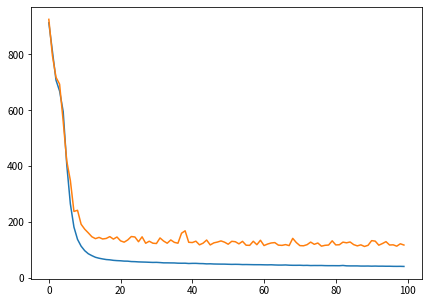

In [47]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(range(len(trainer.train_losses)), trainer.train_losses)
ax.plot(range(len(trainer.val_losses)), trainer.val_losses)
plt.show()

In [430]:
print(trainer.validate(train_loader))
print(trainer.validate(val_loader))

78.99893493652344
109.23197791689918


## 予測結果

In [48]:
model_name = 'AttnEncDec'

In [50]:
model = AttentionEncoderDecoder().to(device=device)
model.load_state_dict(torch.load(f'{config.MODEL_DIR}/{model_name}_71.pth'))
model.eval()

AttentionEncoderDecoder(
  (encoder): Encoder(
    (traffic_encoder): TrafficSearchEncoder(
      (conv): Conv2d(1, 64, kernel_size=(7, 5), stride=(1, 1), padding=(3, 0), padding_mode=replicate)
      (lstm): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
    )
    (search_encoder): TrafficSearchEncoder(
      (conv): Conv2d(1, 64, kernel_size=(7, 5), stride=(1, 1), padding=(3, 0), padding_mode=replicate)
      (lstm): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
    )
    (unspec_search_encoder): SearchUnspecEncoder(
      (conv): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding_mode=replicate)
      (dropout): Dropout(p=0.4, inplace=False)
    )
  )
  (decoder): AttentionDecoder(
    (traffic_decoder): TrafficDecoder(
      (lstm): LSTM(1, 256, num_layers=2, batch_first=True, dropout=0.3)
    )
    (attention): DotProductAttention()
    (affine_decoder): AffineDecoder(
      (datetime_embedding): CategoricalEmbeddi

In [51]:
def pred_data_generator(X_test, y_test, time_step, prediction_horizon=24):
    def create(zero_date, pred_start_date, pred_window, sec_id):
        pred_start_ind = int((pd.Timestamp(pred_start_date) - pd.Timestamp(zero_date)).total_seconds() / (60 * 60))
        pred_end_ind = pred_start_ind + pred_window

        in_start_ind = pred_start_ind - prediction_horizon - time_step + 1
        in_end_ind = pred_end_ind
        
        X_in = X_test[:, in_start_ind:in_end_ind, sec_id]
        y_in = y_test[:, in_start_ind:in_end_ind, sec_id]
        y_true = y_test[0, pred_start_ind:pred_end_ind, sec_id]
        
        return X_in, y_in, y_true
    return create

In [52]:
def predict(model, dataset, device=device):
    model.eval()

    with torch.no_grad():
        data, _ = dataset[:]
        if isinstance(data, (list, tuple)):
            data = map(lambda x: x.to(device=device), data)
        else:
            data = data.to(device=device)
        out = model.generate(data).detach().cpu()

    return out

In [53]:
p_gen = pred_data_generator(X_va, y_va, time_step=time_step)
zero_date = '2022/3/1'

In [54]:
pred_start_date = '2022/5/3'
pred_window = 1 * 24

X_in, y_in, y_true = p_gen(zero_date, pred_start_date, pred_window, sec_id=[34])
dataset_test = STDataset(X_in, y_in, time_step=time_step, space_window=space_window)

In [55]:
out = predict(model, dataset_test)
out = out.view(pred_window, -1)

In [56]:
print('mae', abs(y_true - out).mean().item())
print('mape', (abs(y_true - out) / y_true).mean().item())

mae 561.1781616210938
mape 0.2749384045600891


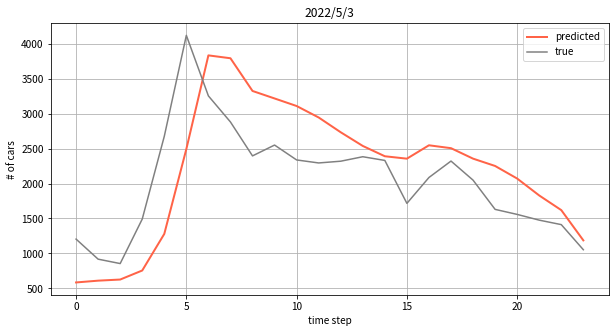

In [57]:
plt.figure(figsize=(10,5))
plt.plot(range(len(out)), out, label='predicted', color='tomato', lw=2)
plt.plot(range(len(y_true)), y_true, label='true', color='gray')
plt.xlabel('time step')
plt.ylabel('# of cars')
plt.title('2022/5/3')
plt.legend()
plt.grid()
plt.show()

In [58]:
pred_start_date = '2022/5/14'
pred_window = 1 * 24 

X_in, y_in, y_true = p_gen(zero_date, pred_start_date, pred_window, sec_id=[34])
dataset_test = STDataset(X_in, y_in, 
                         time_step=time_step,
                         space_window=space_window)

In [59]:
out = predict(model, dataset_test)
out = out.view(pred_window, -1)

In [60]:
print('mae', abs(y_true - out).mean().item())
print('mape', (abs(y_true - out) / y_true).mean().item())

mae 203.79884338378906
mape 0.15087412297725677


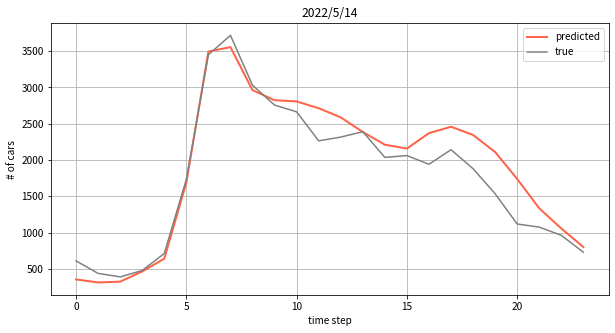

In [61]:
plt.figure(figsize=(10,5))
plt.plot(range(len(out)), out, label='predicted', color='tomato', lw=2)
plt.plot(range(len(y_true)), y_true, label='true', color='gray')
plt.xlabel('time step')
plt.ylabel('# of cars')
plt.title('2022/5/14')
plt.legend()
plt.grid()
plt.show()

In [62]:
pred_start_date = '2022/5/11'
pred_window = 1 * 24

X_in, y_in, y_true = p_gen(zero_date, pred_start_date, pred_window, sec_id=[34])
dataset_test = STDataset(X_in, y_in, 
                         time_step=time_step, 
                         space_window=space_window)

In [63]:
out = predict(model, dataset_test)
out = out.view(pred_window, -1)

In [64]:
print('mae', abs(y_true - out).mean().item())
print('mape', (abs(y_true - out) / y_true).mean().item())

mae 397.349365234375
mape 0.24398772418498993


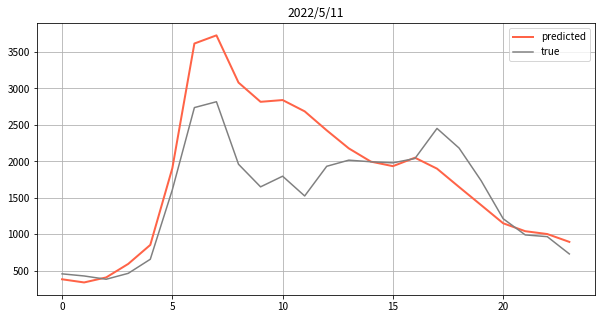

In [65]:
plt.figure(figsize=(10,5))
plt.plot(range(len(out)), out, label='predicted', color='tomato', lw=2)
plt.plot(range(len(y_true)), y_true, label='true', color='gray')
plt.title('2022/5/11')
plt.legend()
plt.grid()
plt.show()

### GW

In [66]:
pred_start_date = '2022/4/29'
pred_window = 9 * 24

X_in, y_in, y_true = p_gen(zero_date, pred_start_date, pred_window, sec_id=[34])
dataset_test = STDataset(X_in, y_in, 
                         time_step=time_step, 
                         space_window=space_window)

In [67]:
out = predict(model, dataset_test)
out = out.view(pred_window, -1)

In [68]:
print('mae', abs(y_true - out).mean().item())
print('mape', (abs(y_true - out) / y_true).mean().item())

mae 375.3688659667969
mape 0.23512548208236694


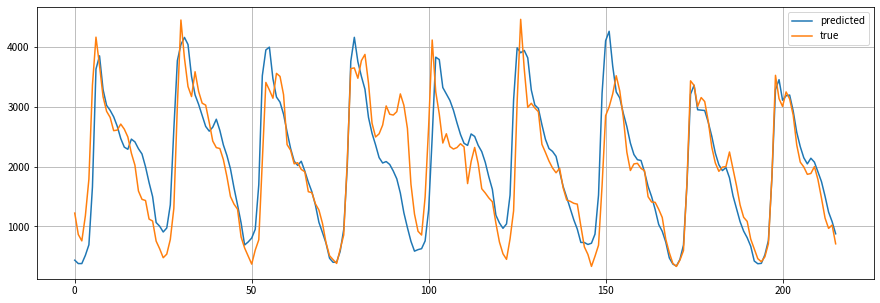

In [69]:
plt.figure(figsize=(15,5))
plt.plot(range(len(out)), out, label='predicted')
plt.plot(range(len(y_true)), y_true, label='true')
plt.legend()
plt.grid()
plt.show()

### 普通の1週間 (月~日)

#### 3月

In [70]:
pred_start_date = '2022/3/21'
pred_window = 7 * 24

X_in, y_in, y_true = p_gen(zero_date, pred_start_date, pred_window, sec_id=[34])
dataset_test = STDataset(X_in, y_in, 
                         time_step=time_step, 
                         space_window=space_window)

In [71]:
out = predict(model, dataset_test)
out = out.view(pred_window, -1)

In [72]:
print('mae', abs(y_true - out).mean().item())
print('mape', (abs(y_true - out) / y_true).mean().item())

mae 271.20513916015625
mape 0.16003327071666718


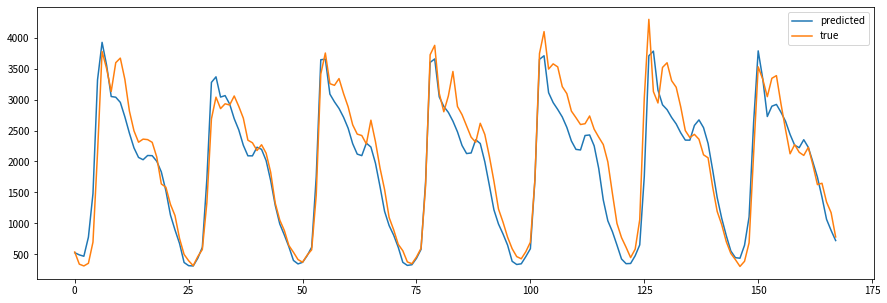

In [73]:
plt.figure(figsize=(15,5))
plt.plot(range(len(out)), out, label='predicted')
plt.plot(range(len(y_true)), y_true, label='true')
plt.legend()
plt.show()

#### 4月

In [74]:
pred_start_date = '2022/4/4'
pred_window = 7 * 24

X_in, y_in, y_true = p_gen(zero_date, pred_start_date, pred_window, sec_id=[27])
dataset_test = STDataset(X_in, y_in, 
                         time_step=time_step, 
                         space_window=space_window)

In [75]:
out = predict(model, dataset_test)
out = out.view(pred_window, -1)

In [76]:
print('mae', abs(y_true - out).mean().item())
print('mape', (abs(y_true - out) / y_true).mean().item())

mae 330.1689758300781
mape 0.19710420072078705


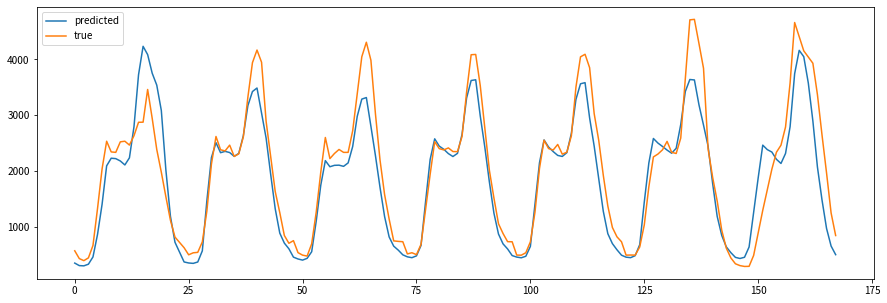

In [77]:
plt.figure(figsize=(15,5))
plt.plot(range(len(out)), out, label='predicted')
plt.plot(range(len(y_true)), y_true, label='true')
plt.legend()
plt.show()

#### 5月

In [78]:
pred_start_date = '2022/5/23'
pred_window = 7 * 24

X_in, y_in, y_true = p_gen(zero_date, pred_start_date, pred_window, sec_id=[27])
dataset_test = STDataset(X_in, y_in, 
                         time_step=time_step,
                         space_window=space_window)

In [79]:
out = predict(model, dataset_test)
out = out.view(pred_window, -1)

In [80]:
print('mae', abs(y_true - out).mean().item())
print('mape', (abs(y_true - out) / y_true).mean().item())

mae 313.9779052734375
mape 0.18489550054073334


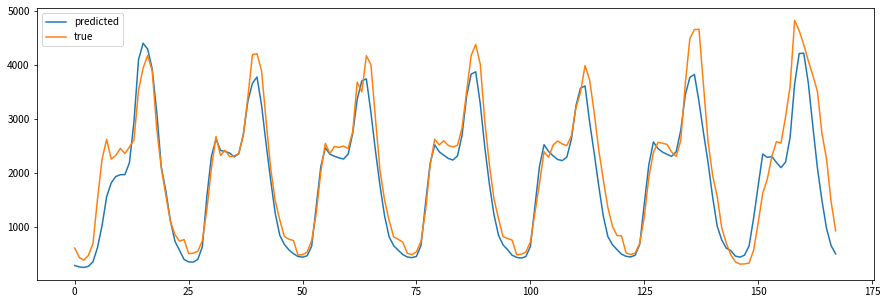

In [81]:
plt.figure(figsize=(15,5))
plt.plot(range(len(out)), out, label='predicted')
plt.plot(range(len(y_true)), y_true, label='true')
plt.legend()
plt.show()